In [ ]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = (
    df['author']
    .value_counts()
    .head(10)
    .index
)

# Keep only top authors
df_top = df[df['author'].isin(top_authors)].copy()

# List unique authors
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper: Remove URLs from text ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---

n = 1500       # chunk size (characters)
min_parts = 2  # minimum number of chunks per author

corpus = {}

for author in authors:
    subset = df_top[df_top.author == author].reset_index()

    # print(f"\nAuthor {author} has {len(subset)} messages")

    # Concatenate all messages from this author into one long string
    longseq = " ".join(subset.message)
    # print(f"Author {author} has {len(longseq)} total characters")

    # Split into n-sized parts
    parts = [longseq[i: i + n] for i in range(0, len(longseq), n)]
    # print(f"Author {author} has {len(parts)} parts pre-cleaning")

    # Clean URLs and remove double spaces
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]

    # print(f"Author {author} has {len(parts)} parts post-cleaning")

    # Only keep authors with enough parts
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Create character 3-gram feature matrix ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))

# Flatten all text chunks into a list
parts = [part for text in corpus.values() for part in text]

# Fit and transform to numeric features
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())

print(f"Feature matrix shape: {X.shape}")  # (num_chunks, num_unique_3grams)

# %%
# --- Load author metadata (Gender, etc.) ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

print(f"Author metadata shape: {author_info_df.shape}")
print(author_info_df.head())

# %%
# --- Prepare labels for clustering ---

# Flatten all author names for each text chunk
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]

# Create lookup dictionary for author → gender
gender_map = author_info_df.set_index("author")["Gender"].to_dict()

# Combine author and gender for labeling, e.g. "Alice (F)"
wa_labels_gender = [f"{author} ({gender_map.get(author, '?')})" for author in wa_labels]

# %%
# --- Run clustering and visualize ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=wa_labels_gender,
    batch=False,
    method="tSNE"
)
# Alternatively:
# clustering(text=text, k=100, labels=wa_labels_gender, batch=False, method="PCA")

# --- Plot formatting ---
plt.legend(title="Author (Gender)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset (colored by gender)")

plt.show()

# %% [markdown]
# 🧠 Interpretation
# 
# Each point = one chunk of text (~2,500 characters).
# Each color = one author (gender shown in legend).
# 
# t-SNE (or PCA) reduces text features to 2D, revealing stylistic clusters.
# 
# If male and female authors cluster separately, it might suggest subtle stylistic or linguistic differences.


In [ ]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = (
    df['author']
    .value_counts()
    .head(10)
    .index
)

# Keep only top authors
df_top = df[df['author'].isin(top_authors)].copy()

# List unique authors
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper: Remove URLs from text ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---

n = 1500       # chunk size (characters)
min_parts = 2  # minimum number of chunks per author

corpus = {}

for author in authors:
    subset = df_top[df_top.author == author].reset_index()

    # Concatenate all messages from this author into one long string
    longseq = " ".join(subset.message)

    # Split into n-sized parts
    parts = [longseq[i: i + n] for i in range(0, len(longseq), n)]

    # Clean URLs and remove double spaces
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]

    # Only keep authors with enough parts
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Create character 3-gram feature matrix ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))

# Flatten all text chunks into a list
parts = [part for text in corpus.values() for part in text]

# Fit and transform to numeric features
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())

print(f"Feature matrix shape: {X.shape}")  # (num_chunks, num_unique_3grams)

# %%
# --- Load author metadata (Gender, Entrance_nr, etc.) ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

print(f"Author metadata shape: {author_info_df.shape}")
print(author_info_df.head())

# %%
# --- Prepare labels for clustering ---

# Flatten all author names for each text chunk
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]

# Create lookup dictionaries for author metadata
gender_map = author_info_df.set_index("author")["Gender"].to_dict()
entrance_map = author_info_df.set_index("author")["Entrance_nr"].to_dict()

# Combine author, gender, and entrance into one label
# Example: "Alice (F, Entrance 3)"
wa_labels_meta = [
    f"{author} ({gender_map.get(author, '?')}, Entrance {entrance_map.get(author, '?')})"
    for author in wa_labels
]

# %%
# --- Run clustering and visualize ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=wa_labels_meta,
    batch=False,
    # method="tSNE"
    method="PCA"
)
# Alternatively:
# clustering(text=text, k=100, labels=wa_labels_meta, batch=False, method="PCA")

# --- Plot formatting ---
plt.legend(title="Author (Gender, Entrance)", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset (colored by gender and entrance)")

plt.show()

# %% [markdown]
# 🧠 Interpretation
# 
# Each point = one chunk of text (~1,500 characters).
# Each color = one author (with gender and entrance shown in legend).
# 
# t-SNE (or PCA) reduces text features to 2D, revealing stylistic clusters.
# 
# If authors from the same entrance or gender cluster together, it may reflect shared communication patterns, tone, or group habits.


In [ ]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = (
    df['author']
    .value_counts()
    .head(10)
    .index
)

# Keep only top authors
df_top = df[df['author'].isin(top_authors)].copy()

# List unique authors
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper: Remove URLs from text ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---

# tSNE
# n = 2500       # chunk size (characters)
# min_parts = 2  # minimum number of chunks per author

# PCA
n = 2000       # chunk size (characters)
min_parts = 4  # minimum number of chunks per author

corpus = {}

for author in authors:
    subset = df_top[df_top.author == author].reset_index()

    # Concatenate all messages from this author into one long string
    longseq = " ".join(subset.message)

    # Split into n-sized parts
    parts = [longseq[i: i + n] for i in range(0, len(longseq), n)]

    # Clean URLs and remove double spaces
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]

    # Only keep authors with enough parts
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Create character 3-gram feature matrix ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))

# Flatten all text chunks into a list
parts = [part for text in corpus.values() for part in text]

# Fit and transform to numeric features
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())

print(f"Feature matrix shape: {X.shape}")  # (num_chunks, num_unique_3grams)

# %%
# --- Load author metadata (Gender, Entrance_nr, etc.) ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

print(f"Author metadata shape: {author_info_df.shape}")
print(author_info_df.head())

# %%
# --- Prepare labels for clustering ---

# Flatten all author names for each text chunk
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]

# Create lookup dictionaries for metadata
gender_map = author_info_df.set_index("author")["Gender"].to_dict()
entrance_map = author_info_df.set_index("author")["Entrance_nr"].to_dict()

# Labels for display in legend (gender only)
wa_labels_gender = [gender_map.get(author, '?') for author in wa_labels]

# %%
# --- Run clustering and visualize ---
# Color points by gender only
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=wa_labels_gender,
    batch=False,
    # method="tSNE"
    method="PCA"
)
# Alternatively:
# clustering(text=text, k=100, labels=wa_labels_gender, batch=False, method="PCA")

# --- Plot formatting ---
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset (colored by gender)")

plt.show()

# %% [markdown]
# 🧠 Interpretation
# 
# Each point = one chunk of text (~1,500 characters).
# Each color = one gender (M / F / ?).
# 
# t-SNE (or PCA) reduces text features to 2D, revealing stylistic clusters.
# 
# If male and female clusters separate, it may indicate subtle stylistic or linguistic differences.
# 
# The clustering ignores author identity — focusing only on gender-based writing style similarities.


In [ ]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = (
    df['author']
    .value_counts()
    .head(10)
    .index
)

# Keep only top authors
df_top = df[df['author'].isin(top_authors)].copy()

# List unique authors
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper: Remove URLs from text ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---

# tSNE
n = 1500       # chunk size (characters)
min_parts = 4  # minimum number of chunks per author

# # PCA
# n = 2000       # chunk size (characters)
# min_parts = 4  # minimum number of chunks per author

corpus = {}

for author in authors:
    subset = df_top[df_top.author == author].reset_index()

    # Concatenate all messages from this author into one long string
    longseq = " ".join(subset.message)

    # Split into n-sized parts
    parts = [longseq[i: i + n] for i in range(0, len(longseq), n)]

    # Clean URLs and remove double spaces
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]

    # Only keep authors with enough parts
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Create character 3-gram feature matrix ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))

# Flatten all text chunks into a list
parts = [part for text in corpus.values() for part in text]

# Fit and transform to numeric features
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())

print(f"Feature matrix shape: {X.shape}")  # (num_chunks, num_unique_3grams)

# %%
# --- Load author metadata (Gender, Entrance_nr, etc.) ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

print(f"Author metadata shape: {author_info_df.shape}")
print(author_info_df.head())

# %%
# --- Prepare labels for clustering ---

# Flatten all author names for each text chunk
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]

# Create lookup dictionary for entrance number
entrance_map = author_info_df.set_index("author")["Entrance_nr"].to_dict()

# Labels for display in legend (Entrance number only)
wa_labels_entrance = [f"Entrance {entrance_map.get(author, '?')}" for author in wa_labels]

# %%
# --- Run clustering and visualize ---
# Color points by entrance number only
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=wa_labels_entrance,
    batch=False,
    method="PCA"
)
# Alternatively:
# clustering(text=text, k=500, labels=wa_labels_entrance, batch=False, method="tSNE")

# --- Plot formatting ---
plt.legend(title="Entrance Number", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset (colored by entrance number)")

plt.show()



Number of top authors: 20

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']


2025-10-14 23:40:36.415 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (165, 11020)
2025-10-14 23:40:36.633 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


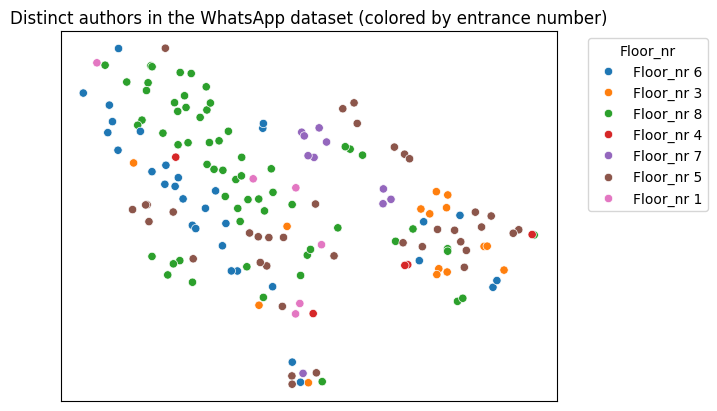

In [9]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = (
    df['author']
    .value_counts()
    .head(20)
    .index
)

# Keep only top authors
df_top = df[df['author'].isin(top_authors)].copy()

# List unique authors
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper: Remove URLs from text ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---

# tSNE
n = 2000       # chunk size (characters)
min_parts = 4  # minimum number of chunks per author

# # PCA
# n = 2000       # chunk size (characters)
# min_parts = 4  # minimum number of chunks per author

corpus = {}

for author in authors:
    subset = df_top[df_top.author == author].reset_index()

    # Concatenate all messages from this author into one long string
    longseq = " ".join(subset.message)

    # Split into n-sized parts
    parts = [longseq[i: i + n] for i in range(0, len(longseq), n)]

    # Clean URLs and remove double spaces
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]

    # Only keep authors with enough parts
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Create character 3-gram feature matrix ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))

# Flatten all text chunks into a list
parts = [part for text in corpus.values() for part in text]

# Fit and transform to numeric features
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())

# print(f"Feature matrix shape: {X.shape}")  # (num_chunks, num_unique_3grams)

# %%
# --- Load author metadata (Gender, Entrance_nr, etc.) ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# print(f"Author metadata shape: {author_info_df.shape}")
# print(author_info_df.head())

# %%
# --- Prepare labels for clustering ---

# Flatten all author names for each text chunk
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]

# Create lookup dictionary for entrance number
# entrance_map = author_info_df.set_index("author")["Entrance_nr"].to_dict()

# meta_item = "Entrance_nr"
meta_item = "Floor_nr"
# meta_item = "Nr_rooms"
# meta_item = "Gender"

legend_map = author_info_df.set_index("author")[meta_item].to_dict()

# Labels for display in legend (Entrance number only)
# wa_labels_entrance = [f"Entrance {entrance_map.get(author, '?')}" for author in wa_labels]
wa_labels_legend_map = [f"{meta_item} {legend_map.get(author, '?')}" for author in wa_labels]

# %%
# --- Run clustering and visualize ---
# Color points by entrance number only
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=wa_labels_legend_map,
    batch=False,
    # method="PCA"
    method="tSNE"
)
# Alternatively:
# clustering(text=text, k=500, labels=wa_labels_entrance, batch=False, method="tSNE")

# --- Plot formatting ---
plt.legend(title=f"{meta_item}", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("Distinct authors in the WhatsApp dataset (colored by entrance number)")

plt.show()



Number of top authors: 20

Final corpus authors: ['cackling-eland', 'carefree-lark', 'cheerful-mule', 'eye-catching-hare', 'flexible-platypus', 'intense-toad', 'limber-ostrich', 'radiant-coyote', 'silky-lapwing', 'snorting-ibex', 'springy-hare', 'sudsy-jellyfish', 'vivid-rhinoceros', 'zany-trout']
Feature matrix shape: (165, 11020)


2025-10-15 00:19:51.472 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (165, 11020)
2025-10-15 00:19:51.708 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


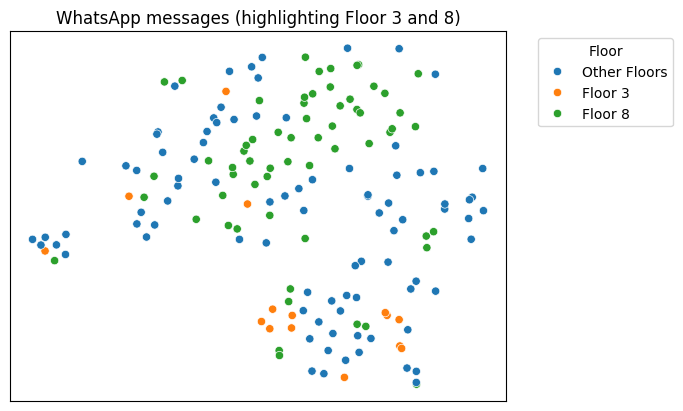

In [13]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(20).index
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
n = 2000       # chunk size
min_parts = 4  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]

floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()
highlight_floors = [3, 8]

# Encode labels: only 3 & 8 colored, rest as 'Other'
wa_labels_floor = []
for author in wa_labels:
    floor = floor_map.get(author, None)
    if floor in highlight_floors:
        wa_labels_floor.append(f"Floor {floor}")
    else:
        wa_labels_floor.append("Other Floors")

# %%
# --- Run clustering ---
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=wa_labels_floor,  # labels determine color
    batch=False,
    method="tSNE"
)

# --- Legend formatting ---
plt.legend(title="Floor", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Floor 3 and 8)")

plt.show()


Number of top authors: 5

Final corpus authors: ['carefree-lark', 'intense-toad', 'springy-hare', 'sudsy-jellyfish', 'vivid-rhinoceros']
Feature matrix shape: (69, 8662)


2025-10-15 00:28:06.220 | INFO     | wa_analyzer.model:fit:35 - Vectorized text into shape (69, 8662)
2025-10-15 00:28:06.254 | INFO     | wa_analyzer.model:reduce_dims:45 - Using t-SNE


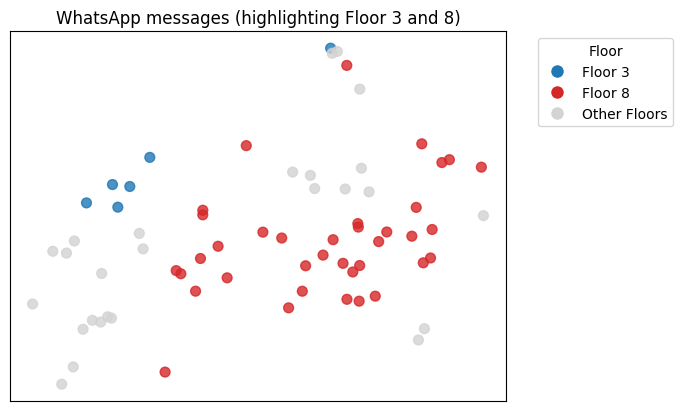

In [31]:
# %%
import seaborn as sns
import pandas as pd
from pathlib import Path
from loguru import logger
import numpy as np
import warnings
import matplotlib.pyplot as plt
import json
import tomllib
import re
from sklearn.feature_extraction.text import CountVectorizer
from wa_analyzer.model import TextClustering

# Initialize clustering model
clustering = TextClustering()

# Ignore warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# %%
# --- Load configuration and data ---
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning(
        "Datafile does not exist. First run src/preprocess.py, and check the timestamp!"
    )

df = pd.read_parquet(datafile)

# %%
# --- Count messages per author ---
top_authors = df['author'].value_counts().head(5).index # default = 20 of 5
df_top = df[df['author'].isin(top_authors)].copy()
authors = list(np.unique(df_top.author))
print(f"Number of top authors: {len(authors)}")

# %%
# --- Helper to remove URLs ---
def remove_url(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

# %%
# --- Create corpus of text chunks per author ---
# sweet spot n = 2000/2500, min_parts = 4/5, of n = 3000, min_parts = 4
n = 3000       # chunk size
min_parts = 2  # minimum chunks

corpus = {}
for author in authors:
    subset = df_top[df_top.author == author].reset_index()
    longseq = " ".join(subset.message)
    parts = [longseq[i:i+n] for i in range(0, len(longseq), n)]
    parts = [remove_url(chunk) for chunk in parts]
    parts = [re.sub(" +", " ", chunk) for chunk in parts]
    if len(parts) > min_parts:
        corpus[author] = parts

print(f"\nFinal corpus authors: {list(corpus.keys())}")

# %%
# --- Feature extraction ---
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
parts = [part for text in corpus.values() for part in text]
X = vectorizer.fit_transform(parts)
X = np.asarray(X.todense())
print(f"Feature matrix shape: {X.shape}")

# %%
# --- Load author metadata ---
with open("nested_users5.json", "r") as f:
    nested_users = json.load(f)

author_info_df = (
    pd.DataFrame(nested_users)
    .T
    .reset_index()
    .rename(columns={'index': 'author'})
)

# %%
# --- Prepare labels for clustering ---
wa_labels = [k for k, v in corpus.items() for _ in range(len(v))]
floor_map = author_info_df.set_index("author")["Floor_nr"].to_dict()
highlight_floors = [3, 8]

# Encode labels and assign colors
labels_for_plot = []
colors = []
for author in wa_labels:
    floor = floor_map.get(author, None)
    if floor == 3:
        labels_for_plot.append("Floor 3")
        colors.append("tab:blue")
    elif floor == 8:
        labels_for_plot.append("Floor 8")
        colors.append("tab:red")
    else:
        labels_for_plot.append("Other Floors")
        colors.append("lightgrey")

# %%
# --- Run clustering ---
# Note: TextClustering does not accept colors, so we just use it for positions
clustering(
    text=[part for text in corpus.values() for part in text],
    k=500,
    labels=None,  # We'll handle coloring manually
    batch=False,
    method="tSNE"
    #  method="PCA"
)

# %%
# --- Overlay points with manual colors ---
# Extract the scatter points from the last clustering plot
sc = plt.gca().collections[0]
offsets = sc.get_offsets()

plt.clf()  # Clear previous plot
plt.scatter(offsets[:, 0], offsets[:, 1], c=colors, s=50, alpha=0.8)

# Legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:blue', markersize=10, label='Floor 3'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='tab:red', markersize=10, label='Floor 8'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=10, label='Other Floors')
]
plt.legend(handles=legend_elements, title="Floor", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.xticks([])
plt.yticks([])
plt.title("WhatsApp messages (highlighting Floor 3 and 8)")

plt.show()
